This file conducts and exploratory analysis on the magnatuneatag dataset. Here are useful links:
- https://github.com/keunwoochoi/magnatagatune-list?tab=readme-ov-file
- https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from zipfile import ZipFile 
import os
import librosa
from matplotlib import pyplot as plt
import cv2
import json
pd.options.mode.chained_assignment = None  # default='warn'
from imgaug import augmenters as iaa
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from keras.callbacks import EarlyStopping

2024-04-17 00:47:42.267500: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 00:47:42.309840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 00:47:42.989283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


I used `cat mp3.zip.* > mp3_all.zip` to concat the 3 compressed folders from the links above and unzip them below

In [2]:
# # loading the zip file and creating a zip object 
# with ZipFile("/home/mendu/Thesis/data/magnatagatune/mp3_all.zip", 'r') as zObject: 
#     zObject.extractall(path="/home/mendu/Thesis/data/magnatagatune/audio") 

I ran `find audio -type f -name "*.mp3" -exec mv {} audio \;` to get all the .mp3 files into the audio folder and
`find audio -type d -empty -delete` to delete the empty folders

In [3]:
# Checking the no. of audio files
audio_dir = '/home/mendu/Thesis/data/magnatagatune/audio'
audio_list = os.listdir(audio_dir)
audio_list = [file_name.replace('.wav.mp3', '') for file_name in audio_list] # list of audio track names
print('Total number of audio files', len(audio_list))

Total number of audio files 25863


In [4]:
#Importing the tags csv file
df = pd.read_csv('/home/mendu/Thesis/data/magnatagatune/tag_annotations.csv',sep = "\t" ,index_col=[0])
df['mp3_path'] = [i[2:] for i in df['mp3_path']] 

In [5]:
# List of the most frequent genre tags
genre = ['classical', 'clasical', 'classic', 'techno', 'electronic', 'electro', 'electronica', 
 'electric', 'rock', 'indian', 'india', 'opera', 'operatic', 'pop', 'new age', 'dance', 
 'country', 'metal', 'heavy', 'heavy metal']

# Dictionary of genre tags that are synonyms
synonym_dict = {'classical':['classical', 'clasical', 'classic'],
                'electronic': ['electronic', 'electro', 'electronica', 'electric', 'techno'],
                'indian': ['indian', 'india'],
                'opera': ['opera', 'operatic'],
                'metal': ['metal', 'heavy', 'heavy metal']}

genre.append('mp3_path')

df = df[genre]

In [6]:
df

,classical,clasical,classic,techno,electronic,electro,electronica,electric,rock,indian,...,opera,operatic,pop,new age,dance,country,metal,heavy,heavy metal,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,american_bach_soloists-j_s__bach_solo_cantatas...
6,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,american_bach_soloists-j_s__bach_solo_cantatas...
10,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,american_bach_soloists-j_s__bach_solo_cantatas...
11,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,american_bach_soloists-j_s__bach_solo_cantatas...
12,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,american_bach_soloists-j_s__bach_solo_cantatas...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,jacob_heringman-blame_not_my_lute-56-la_bressa...
58906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,jacob_heringman-blame_not_my_lute-57-lost_is_m...
58907,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,jacob_heringman-blame_not_my_lute-57-lost_is_m...


In [7]:
# Creating a single column for all the tags
df['tags'] = df.apply(lambda row: (','.join(row.index[row == 1])).split(','), axis=1)

df = df[['mp3_path', 'tags']]

In [8]:
df

,mp3_path,tags
clip_id,,
2,american_bach_soloists-j_s__bach_solo_cantatas...,"[classical, opera]"
6,american_bach_soloists-j_s__bach_solo_cantatas...,"[classical, classic, opera]"
10,american_bach_soloists-j_s__bach_solo_cantatas...,"[classical, classic, opera]"
11,american_bach_soloists-j_s__bach_solo_cantatas...,[opera]
12,american_bach_soloists-j_s__bach_solo_cantatas...,"[classical, classic]"
...,...,...
58899,jacob_heringman-blame_not_my_lute-56-la_bressa...,[]
58906,jacob_heringman-blame_not_my_lute-57-lost_is_m...,[]
58907,jacob_heringman-blame_not_my_lute-57-lost_is_m...,[classical]


In [9]:
# nested for loop to replace the synonyms
for idx, row in df.iterrows(): #iterates over the rows
    new_tags = []
    for tag in row['tags']: #iterates over each element in the aspect_list list
        for key, values in synonym_dict.items(): #iterates over same_tags dictionary
            if tag in values:
                new_tags.append(key)
                break
        else:
            new_tags.append(tag)
    
    # Making sure the tags are unique in each row        
    new_tags = list(set(new_tags))       
    
    #If multiple tags drop classical if available 
    if len(row['tags'])>1 and 'classical' in row['tags']: #if that are more than one tags and one of it is instrumental drop instrumental
        new_tags.remove('classical')
        
    # updating the tags     
    df.at[idx, 'tags'] = new_tags


# removing empty tags rows
df = df[df['tags'].apply(lambda x: any(x))]

df = df[df['tags'].apply(lambda x: len(x) == 1)].reset_index(drop=True)

df['tags'] = df['tags'].apply(lambda x: x[0])


In [10]:
df.tags.value_counts()

tags
classical     3191
electronic    2748
opera         1259
indian        1234
rock          1230
pop            431
country        354
new age        328
dance           39
metal           16
Name: count, dtype: int64

## Generating mel-spectrograms

In [11]:
# Function to convert mp3 files to mel-spectrograms
def mp3_to_melspectrogram(input_folder, output_folder, mp3_name_list):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # List to store the names of problematic files
    problematic_files = []

    # Iterate over each file in the input folder
    for filename in mp3_name_list:
        try:
            # Load the audio file
            audio_path = os.path.join(input_folder, filename)
            y, sr = librosa.load(audio_path)

            # Compute the mel-spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

            # Convert to decibel scale
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Save the mel-spectrogram as .npy file
            output_path = os.path.join(output_folder, filename.replace('.mp3', '.npy'))
            np.save(output_path, mel_spectrogram_db)

            # print(f"Mel-spectrogram saved: {output_path}")
        
        except Exception as e:
            # Handle the exception (e.g., skip the file, log the filename)
            print(f"Error processing {filename}: {str(e)}")
            problematic_files.append(filename)

    # Return the list of problematic files
    return problematic_files

        

In [12]:
#generating mel-specs
input_folder = audio_dir
output_folder = '/home/mendu/Thesis/data/magnatagatune/mel-specs'
# mp3_to_melspectrogram(input_folder, output_folder, df.mp3_path.tolist())

In [13]:
len(os.listdir('/home/mendu/Thesis/data/magnatagatune/mel-specs'))

10829

In [14]:
# removing the .mp3 file causing problems
problematic_file = 'jacob_heringman-josquin_des_prez_lute_settings-19-gintzler__pater_noster-204-233.mp3'

df = df[df['mp3_path'] != problematic_file]

In [15]:
#Checking if there is a mel-spec for every row in the df
df_filenames = df.mp3_path.apply(lambda x: x[:-4]).tolist()
mel_list = [x[:-4] for x in os.listdir(output_folder)]

sorted(df_filenames) == sorted(mel_list)

True

# Training the model

In [16]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (image.shape[0], image.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(image.shape, np.float32)

    #adding the noise to the original image
    noisy_image = image + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [17]:
len(df.mp3_path.to_list())

10829

In [31]:
#the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/magnatagatune/mel-specs'

#The ordered list of all the filenames in the filtered_df
audio_names_list = df.mp3_path.to_list()

filename_npy = str(audio_names_list[0][:-4]) + '.npy'
file_path = os.path.join(folder_path_mel, filename_npy)
  
img = np.load(file_path)

img

array([[-80.      , -71.3518  , -51.834953, ..., -41.400284, -52.311333,
        -80.      ],
       [-80.      , -68.57017 , -46.863937, ..., -39.63662 , -48.272797,
        -80.      ],
       [-80.      , -73.99743 , -46.09658 , ..., -30.220697, -43.78865 ,
        -80.      ],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

In [18]:
#loading the cropped .npy files in a tensor

#the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/magnatagatune/mel-specs'

#The ordered list of all the filenames in the filtered_df
audio_names_list = df.mp3_path.to_list()

data = []
i = 0

for filename in audio_names_list: #iterates over the filtered_df audio names
  filename_npy = str(filename[:-4]) + '.npy'
  file_path = os.path.join(folder_path_mel, filename_npy) #creates a folder path for the mel_specs 
  img = np.load(file_path)
  data.append(add_gauss_noise(img))
  
  # # Check to ensure the image has the minimum required dimensions
  # if img.shape[0] >= 128 and img.shape[1] >= 431:
  #   img = img[:128, :431]
  #   data.append(add_gauss_noise(img))
  # else:
  #   print(f"Error with file: {filename_npy}. Expected minimum shape of (128, 431) but got {img.shape}.")
  #   # Handle the error properly, either skip this image or pad/crop it accordingly

  # To ensure that the files are getting loaded in the correct order
  if i < 10 :
    print(filename)
  i = i+1

data = np.array(data)

american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-30-59.mp3
american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-146-175.mp3
american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-262-291.mp3
american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-291-320.mp3
lvx_nova-lvx_nova-01-contimune-30-59.mp3
american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-117-146.mp3
steven_devine-portrait_of_an_english_harpsichord-01-lesson_1_in_g_major_prelude_james_nares-30-59.mp3
the_headroom_project-jetuton_andawai-01-linda_morena-88-117.mp3
american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-30-59.mp3
american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-146-175.mp3


In [19]:
df.head(10)

,mp3_path,tags
0,american_bach_soloists-j_s__bach_solo_cantatas...,opera
1,american_bach_soloists-j_s__bach_solo_cantatas...,opera
2,american_bach_soloists-j_s__bach_solo_cantatas...,opera
3,american_bach_soloists-j_s__bach_solo_cantatas...,opera
4,lvx_nova-lvx_nova-01-contimune-30-59.mp3,electronic
5,american_bach_soloists-j_s__bach__cantatas_vol...,classical
6,steven_devine-portrait_of_an_english_harpsicho...,classical
7,the_headroom_project-jetuton_andawai-01-linda_...,pop
8,american_bach_soloists-heinrich_schutz__musica...,opera
9,american_bach_soloists-heinrich_schutz__musica...,opera


In [20]:
#normalize data
data = data.astype('float32')/255.0

data.shape

(10829, 128, 1255)

In [21]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 1255, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, pd.get_dummies(df['tags']), test_size=0.1, random_state=42)

# The code for splitting data if oversampling
# X_train, X_val, y_train, y_val = train_test_split(data, filtered_df['aspect_list'], test_size=0.3, random_state=42)

In [22]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train)

In [23]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]
num_classes

10

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2

# l2 regularization
ltwo_reg = 0.07

# Initialize the model
model = Sequential()

# Convolution layers
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(ltwo_reg), input_shape=( 128, 1255, 1), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# New convolutional layers
model.add(Conv2D(256, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers with L2 regularization
model.add(Dense(128, kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(ltwo_reg)))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 1253, 32)  │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 1253, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 126, 1253, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 626, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 624, 64)    │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 61, 624, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 61, 624, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 312, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 310, 128)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 310, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 310, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 155, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 153, 256)   │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 153, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 12, 153, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 76, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 74, 512)     │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 74, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 4, 74, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 37, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 37888)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,849,664 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,422,442 (24.50 MB)

 Trainable params: 6,420,202 (24.49 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [27]:
#Fitting the model and early stopping
early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    # class_weight=class_weight_dict,
    callbacks=[early_stopper]
)

Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.5370 - loss: 20.9033 - val_accuracy: 0.1283 - val_loss: 3.2276
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.6081 - loss: 2.2379 - val_accuracy: 0.2613 - val_loss: 3.1023
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.6306 - loss: 1.9715 - val_accuracy: 0.4755 - val_loss: 2.4283
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.6185 - loss: 2.0057 - val_accuracy: 0.3001 - val_loss: 2.9136
Epoch 5/100
 25/305 ━━━━━━━━━━━━━━━━━━━━ 5:07 1s/step - accuracy: 0.5948 - loss: 2.1249

KeyboardInterrupt: 

In [28]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [29]:
y_val

,classical,country,dance,electronic,indian,metal,new age,opera,pop,rock
3602,False,False,False,True,False,False,False,False,False,False
101,False,False,False,True,False,False,False,False,False,False
8727,False,True,False,False,False,False,False,False,False,False
4972,False,False,False,False,False,False,False,False,False,True
5885,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
8983,True,False,False,False,False,False,False,False,False,False
9988,True,False,False,False,False,False,False,False,False,False
5739,False,False,False,False,True,False,False,False,False,False
2227,False,False,False,False,False,False,False,False,True,False


In [30]:
class_labels = ['classical', 'country', 'dance', 'electronic', 'indian', 'metal', 
               'new age', 'opera', 'pop', 'rock']

predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)  # Converting probabilities to class labels
ground_truth = np.argmax(y_val, axis=1)  # Converting one-hot encoded ground truth to class labels

# Reshape predicted_labels and ground_truth to be 1D arrays
predicted_labels = np.reshape(predicted_labels, (-1,))
ground_truth = np.reshape(ground_truth, (-1,))

predicted_labels = [class_labels[i] for i in predicted_labels]
ground_truth = [class_labels[i] for i in ground_truth]

# Creating a table with prediction and ground truth
comparison_table = pd.DataFrame({'Predicted': predicted_labels, 'Ground Truth': ground_truth})

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step


In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

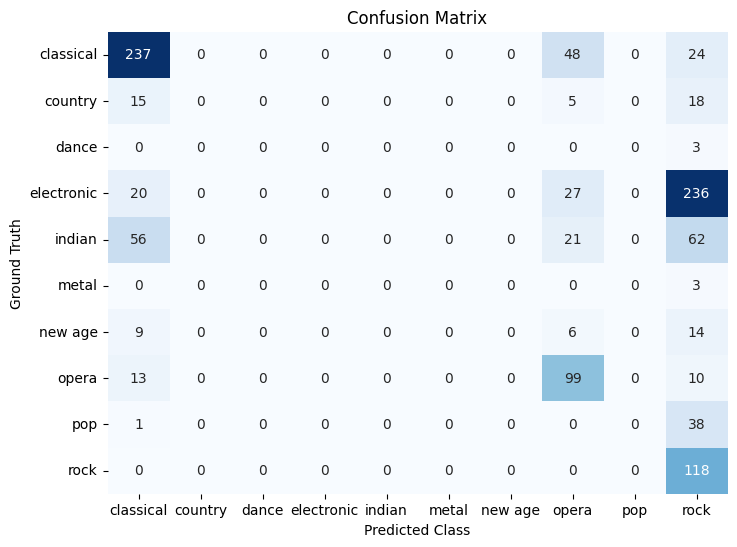

In [32]:
# Get unique class labels
unique_labels = sorted(comparison_table['Ground Truth'].unique())

# Create confusion matrix
conf_matrix = confusion_matrix(comparison_table['Ground Truth'], comparison_table['Predicted'], labels=unique_labels)

# Convert confusion matrix to DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels, columns=unique_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()